<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula04b_XOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

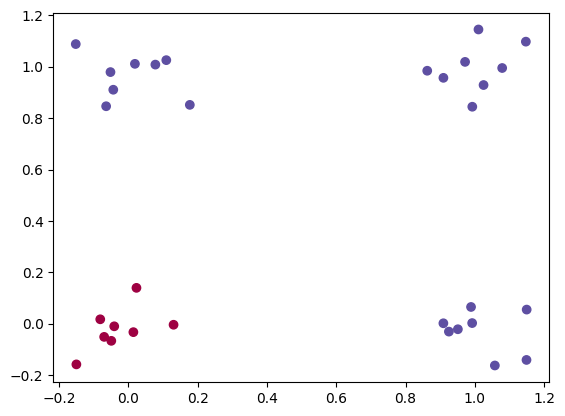

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    return plt


def plot_hiperplano(vector, intercept):
  xs = np.array([0, 1])
  ys = -(vector[0] * xs + intercept) / vector[1]
  plt.plot(xs, ys, '-')


def make_logical_dataset(n=40, func=lambda a, b: bool(a) or bool(b)):
  X, y = make_blobs(n_samples=n,
                     centers=[[0,0],[1,0],[1,1],[0,1]],
                     cluster_std=0.1)
  y = np.array([func(a>0.5, b>0.5) for a, b in zip(X[:, 0], X[:, 1])], dtype=int) * 2 - 1
  return X, y


def define_axes(X, offset):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]


def plot_predictions(clf, X, offset = 0.5):
    axes = define_axes(X, offset)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


X, y = make_logical_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
_ = plot_dataset(X_train, y_train)

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from abc import ABC, abstractstaticmethod, abstractmethod

class Cost(ABC):
  @abstractstaticmethod
  def getCost(y, ypred):
    pass
  @abstractstaticmethod
  def getGradient(y, ypred, X):
    pass

class WidrowHoff(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y-ypred)

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y):
    pass

class GradientDescent(TrainingAlgorithm):
  def __init__(self, max_iter=1000, learning_rate=0.001,
               regularization=0,
               cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      error = y - ypred
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.getGradient(y, ypred, X) * self.learning_rate
      if self.cost.getCost(y, ypred) == 0:
        break
    return w

[[-0.43578062]
 [ 0.95961616]
 [ 0.95005828]]
1.0


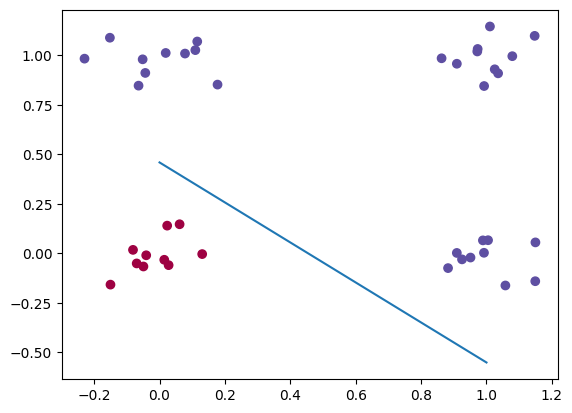

In [31]:
from sklearn.preprocessing import LabelBinarizer

def sign(a):
  return (a>=0)*2-1

def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, trainingAlgorithm=GradientDescent()):
    self.trainingAlgorithm = trainingAlgorithm

  def fit(self, X, y):
    self.labelBinarizer = LabelBinarizer()
    y = self.labelBinarizer.fit_transform(y)
    y = y * 2 - 1
    Xb = include_bias(X)
    self.w = self.trainingAlgorithm.getW(Xb, y)
    return self

  def predict(self, X):
    Xb = include_bias(X)
    ypred = Xb @ self.w
    if self.w.shape[1] == 1:
      ypred = sign(ypred)
    else:
      tmp = np.zeros(ypred.shape)
      idx = np.argmax(ypred, axis=1)
      tmp[np.arange(ypred.shape[0]), idx] = 1
      ypred = tmp
    ypred = self.labelBinarizer.inverse_transform(ypred)
    return ypred

model = NeuralNetwork(trainingAlgorithm=GradientDescent())
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hiperplano(vector=model.w[1:], intercept=model.w[0])
plt.show()


[[-1.49468083]
 [ 0.97178216]
 [ 1.01290391]]
1.0


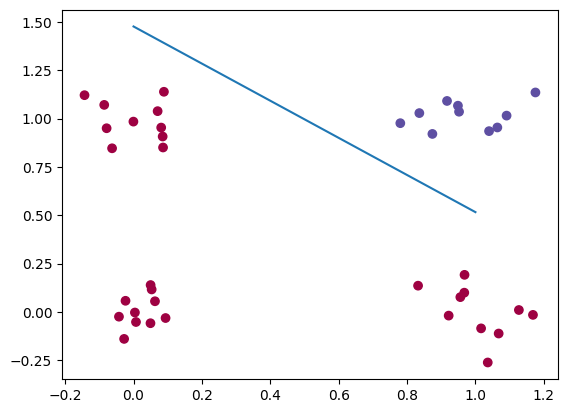

In [32]:
X, y = make_logical_dataset(func=lambda a, b: bool(a) and bool(b))
model = NeuralNetwork(trainingAlgorithm=GradientDescent())
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hiperplano(vector=model.w[1:], intercept=model.w[0])
plt.show()

[[ 0.00272474]
 [-0.03851724]
 [ 0.03353438]]
0.5


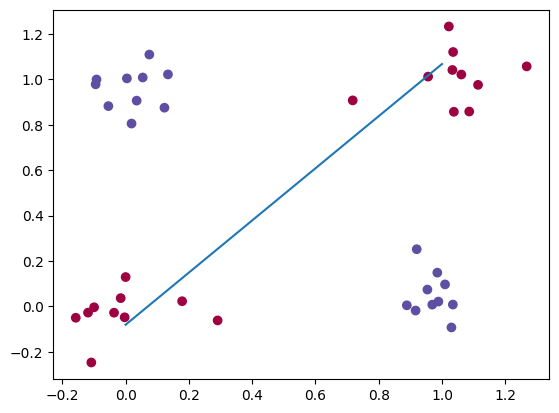

In [33]:
X, y = make_logical_dataset(func=lambda a, b: bool(a) != bool(b))
model = NeuralNetwork(trainingAlgorithm=GradientDescent())
model.fit(X, y)
ypred = model.predict(X)
print(model.w)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hiperplano(vector=model.w[1:], intercept=model.w[0])
plt.show()

In [34]:
class XORClassifier(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    pass
  def predict(self, X):
    Xb = include_bias(X)
    self.ihw = np.array([[0.5, -1, 1], [0.5, 1, -1]]).T
    self.pH = Xb @ self.ihw
    self.H = sign(self.pH)
    Hb = include_bias(self.H)
    self.how = np.array([0.5, -1, -1])
    ypred = Hb @ self.how
    return sign(ypred)

model = XORClassifier()
ypred = model.predict(X)
print(accuracy_score(y, ypred))

1.0


In [35]:
def define_axes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

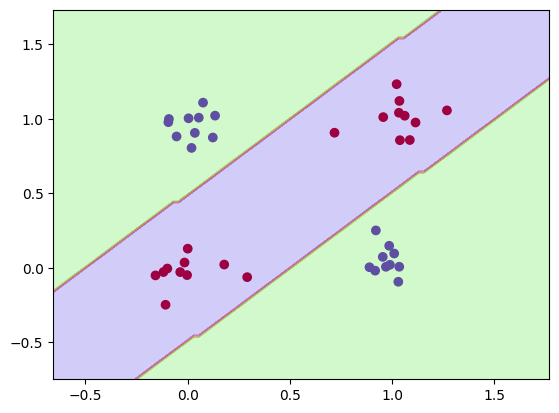

In [36]:
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()

1.0


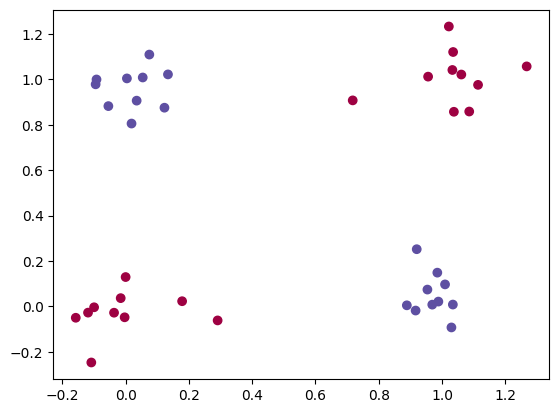

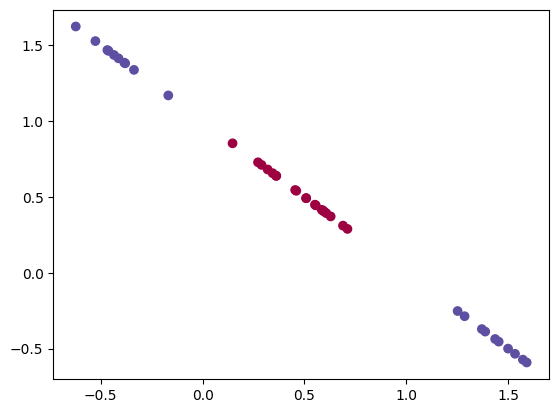

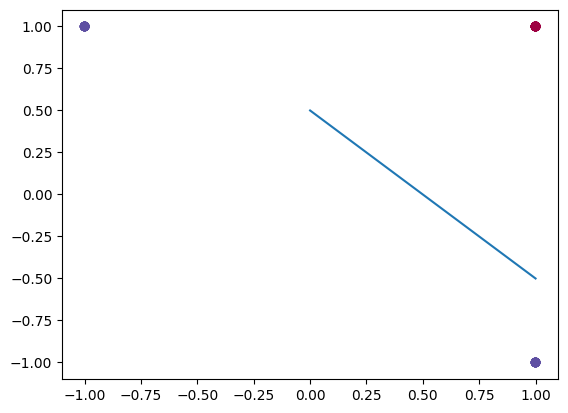

In [37]:
model = XORClassifier()
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X,y)
plt.show()
plot_dataset(model.pH, y)
plt.show()
plot_dataset(model.H, y)
plot_hiperplano(vector=model.how[1:], intercept=model.how[0])
plt.show()

1.0


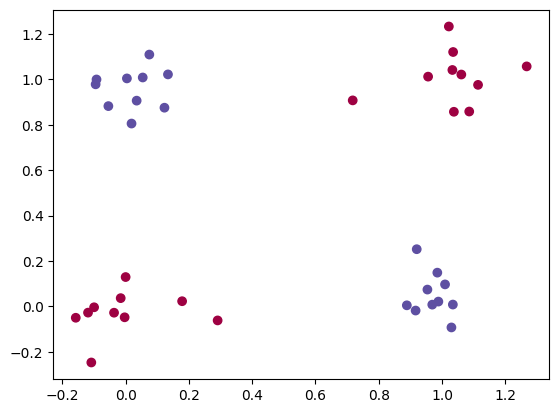

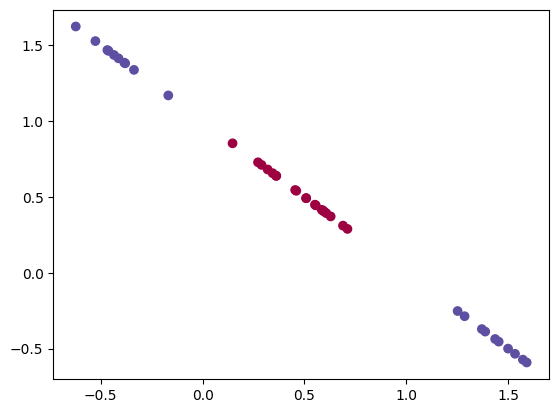

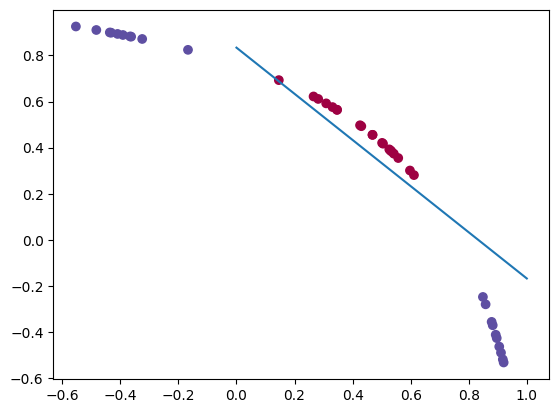

In [38]:
def tanh(a):
  return np.tanh(a)

class XORClassifierTanh(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    pass
  def predict(self, X):
    Xb = include_bias(X)
    self.ihw = np.array([[0.5, -1, 1], [0.5, 1, -1]]).T
    self.pH = Xb @ self.ihw
    self.H = tanh(self.pH)
    Hb = include_bias(self.H)
    self.how = np.array([0.75, -0.9, -0.9])
    ypred = Hb @ self.how
    return sign(ypred)

model = XORClassifierTanh()
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X,y)
plt.show()
plot_dataset(model.pH, y)
plt.show()
plot_dataset(model.H, y)
plot_hiperplano(vector=model.how[1:], intercept=model.how[0])
plt.show()

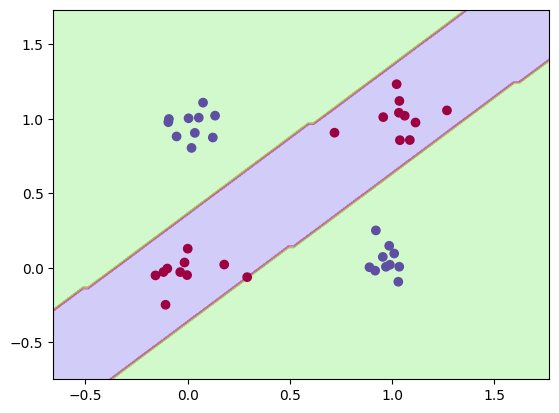

In [39]:
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()